In [184]:
import pandas as pd
import numpy as np
import cpi
from tqdm import tqdm, tqdm_notebook
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

### Data has been uploaded without removing or limiting any values. 
### The cost features have been adjusted for inflation and the nulls have been replaced with that year's median cost.

In [ ]:
file_path_1 = '/Users/jenniferpaige/Desktop/TTS_10-Dec-2019_p1.csv'
file_path_2 = '/Users/jenniferpaige/Desktop/TTS_10-Dec-2019_p2.csv'
files = [file_path_1, file_path_2]
loaded_files = []
count = 0
#load in files
for i in tqdm(range(1, len(files)+1)):
    exec(f"df{i} = pd.read_csv(files[{count}],encoding='iso-8859-1', parse_dates=['Installation Date'], usecols=['Installation Date','System Size','Total Installed Price','Customer Segment', 'State'],na_values=(-9999, '-9999'))")
    count+=1
[exec("loaded_files.append(df{})".format(i)) for i in range(1, len(files)+1)]
if len(loaded_files) > 1:
    df = pd.concat([i for i in loaded_files],ignore_index=True)
else: 
    df=loaded_files[0]

# clean up columnn names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

#sort values by installation date
df.sort_values('installation_date', inplace=True)

#set installation date as index
df.set_index('installation_date', drop=True, inplace=True)

#replace nulls with that year's median cost
[df['total_installed_price'].replace(np.nan,round(df.loc[(df['total_installed_price'] != np.nan) & (df.index.year == i)]['total_installed_price'].median(),2),inplace=True) for i in tqdm(range(1998,2019))] 

#create date and year column for ease
df['date'] = df.index.date
df['year'] = df.index.year

#adjust prices for inflation 
df['adj_installed_price'] = round(df.apply(lambda x:cpi.inflate(x.total_installed_price, x.date), axis=1),2)

#create cost_per_watt target value
df['cost_per_watt'] = round(df['adj_installed_price']/ df['system_size']/1000,2)

In [40]:
#create df of costs per size of system within bins
sys_bins = [0.0, 2.5, 5.0, 7.5, 10, 12.5, 17.5, 42.5, 18000]
df['sys_size_group'] = pd.cut(df['system_size'], sys_bins)
size_df = df.copy()
size_dummies = pd.get_dummies(size_df['sys_size_group'])
size_df = pd.concat([size_df, size_dummies], axis=1)
sizes_nums = []
[sizes_nums.append( str(size_df.sys_size_group[i])) for i in tqdm(range(len(size_df)))]
size_df['size_group'] = sizes_nums

# Create a timeline of days since first observation
df['num_of_days']  = (df['date'] - df['date'][0]).dt.days

# create count for easier visibility when using "groupby"
df['count'] = 0

#create cost per watt by state df 
states = df[['state', 'cost_per_watt',]]
states.rename(columns={'cost_per_watt':'count'},inplace=True)
states = states.groupby('state').count()
states.sort_values('count')
states['state'] = states.index

# issue of 'nan' in df['customer_segment'].unique()
segs = ['RES', 'NON-RES', 'SCHOOL','COM', 'GOV', 'NON-PROFIT']

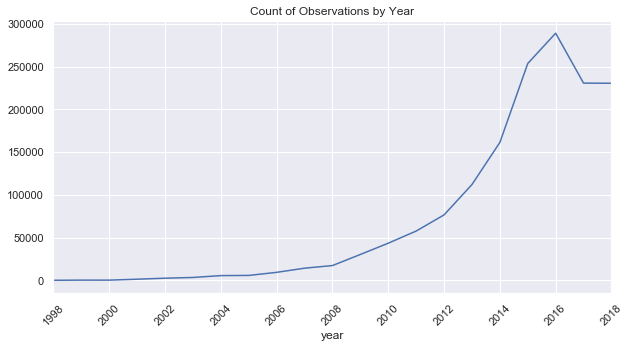

In [328]:
df.groupby('year')['count'].count().plot(figsize=(10,5))
plt.xticks(ticks= list(size_df.year.unique())[::2], rotation=45)
plt.title('Count of Observations by Year')
plt.show()

#  GENERAL COST EDA

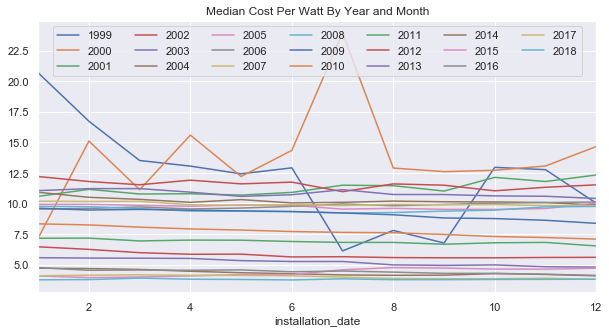

In [333]:
pd.pivot_table(df, values='cost_per_watt',aggfunc='median', columns='year', index=df.index.month, fill_value='-').plot(figsize=(10,5))
plt.legend(loc='upper center', ncol=7)
plt.title("Median Cost Per Watt By Year and Month")
plt.show()

### From the above, it appears as time went on, the less and less volitile the cost_per_watt became for each year. 

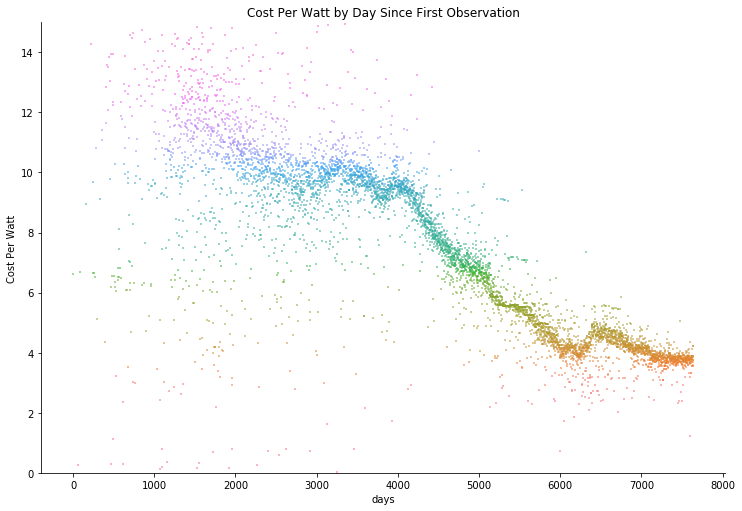

In [18]:
# Looking at the medain cost per watt over time
MedByDay = df.groupby(['num_of_days'])['cost_per_watt'].median()
MedByDay = MedByDay.reset_index()
g = sns.FacetGrid(MedByDay, hue='cost_per_watt', height=7, aspect=1.5)
g.map(plt.scatter, 'num_of_days', 'cost_per_watt', s=5, marker='+', alpha=0.5)
g.ax.set(xlabel='days',
         ylabel='Cost Per Watt', ylim=(0,15),
         title='Cost Per Watt by Day Since First Observation')
plt.show()

### Plot shows a general downward trend of cost 

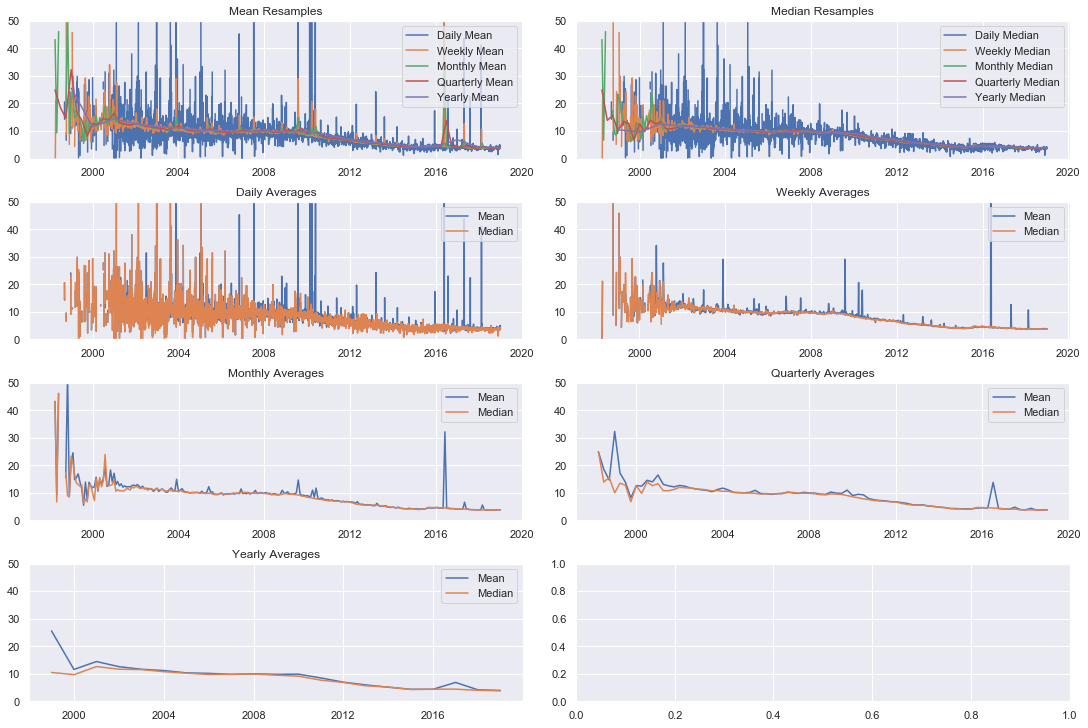

In [336]:
fig, ax = plt.subplots(4,2, figsize=(15,10), constrained_layout=True)
time_list,resam_list,loc_list = ['Daily', 'Weekly', 'Monthly', 'Quarterly', 'Yearly'], ['mean', 'median'], []
[(loc_list.append([i,0]), loc_list.append([i,1])) for i in range(4)]
time_cnt, count = 0,0

for t in time_type:
    for i in range(2):
        exec(f"ax{loc_list[i]}.plot(df.cost_per_watt.resample('{time_list[time_cnt][:1]}').{resam_list[i]}(), label='{time_list[time_cnt]} {resam_list[i]}'.title()) ")
        exec(f"ax{loc_list[i]}.set_title('{resam_list[i]} Resamples'.title())")
    time_cnt+=1
    
for i in range (2,7):
    for r in range(2):
        exec(f"ax{loc_list[i]}.plot(df.cost_per_watt.resample('{time_list[count][:1]}').{resam_list[r]}(), label='{resam_list[r]}'.title())")
        exec(f"ax{loc_list[i]}.set_title('{time_list[count]} averages'.title())")
    count+=1

for i in range(7):
    exec(f"ax{loc_list[i]}.legend(loc='upper right')")
    exec(f"ax{loc_list[i]}.set_ylim(0,50)")

### The median averages of each time period shows less volatility than the mean averages and therefore seems more helpful in utilizing this type of average for time series forecasting and for stationarity.

### The data shows a lot of volitility in early observations which could have been a result of a variety of causes such as irregular intervals of data collection, ignorance of market pricing, nonuniformity of technology and best practices, etc.

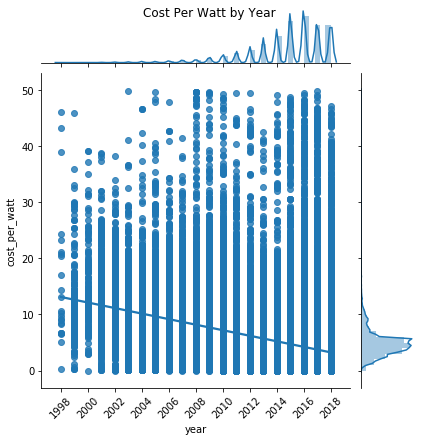

In [11]:
sns.jointplot(y='cost_per_watt' , x='year' , kind='reg', data=size_df.loc[size_df['cost_per_watt'] < 50])
plt.xticks(ticks= list(size_df.year.unique())[::2], rotation=45)
plt.suptitle('Cost Per Watt by Year')
#plt.savefig("cost_per_watt_by_year_scatter.png")
plt.show()

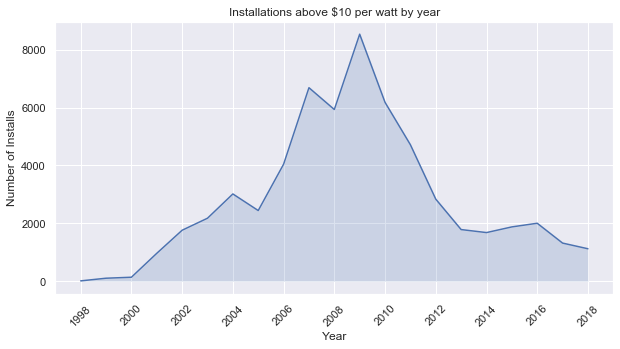

In [339]:
plt.figure(figsize=(10,5))
plt.plot(df.loc[df.cost_per_watt >10].groupby('year').count().system_size)
plt.fill_between(df.year.unique(), df.loc[df.cost_per_watt >10].groupby('year').count().system_size.values, 0, alpha=.2)
plt.title('Installations above $10 per watt by year')
plt.xlabel('Year')
plt.ylabel('Number of Installs')
plt.xticks(ticks= list(df.year.unique())[::2], rotation=45)
#plt.savefig("cost_per_watt_above_10.png")
plt.show()

### The above shows the 59,342 observations where cost per watt was above 10 dollars

### You would think with the general downward trend of the cost would show similiarly here, however it seems odd that the amount of installs above 10 dollars per watt would have a peak in the middle of the time line. 

----

# SYSTEM SIZE EDA

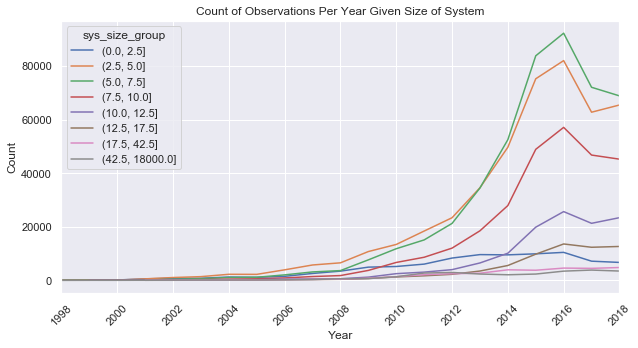

In [340]:
df.pivot_table(values='cost_per_watt',aggfunc='count', index='year', columns='sys_size_group').plot(figsize=(10,5))
plt.xticks(ticks= list(size_df.year.unique())[::2], rotation=45)
plt.title('Count of Observations Per Year Given Size of System')
plt.ylabel('Count')
plt.xlabel('Year')
plt.show()

### As time goes on, the more varied the use of different system sizes becomes

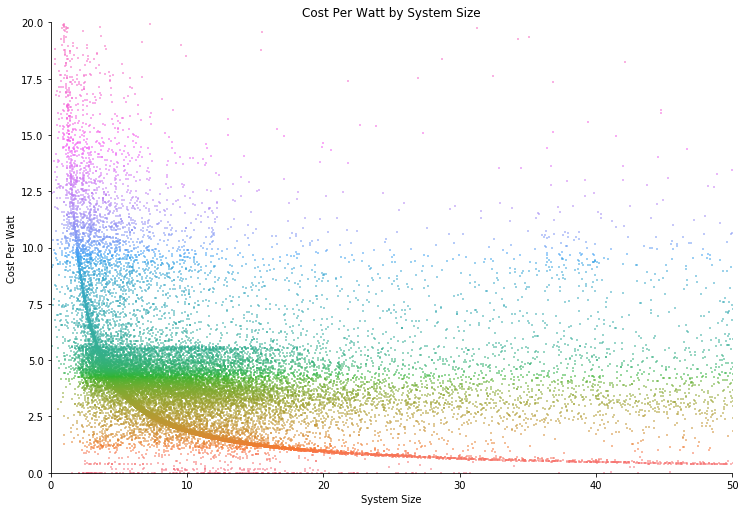

In [19]:
MedByDay = df.groupby(['system_size'])['cost_per_watt'].median()
MedByDay = MedByDay.reset_index()
g = sns.FacetGrid(MedByDay, hue='cost_per_watt', height=7, aspect=1.5)
g.map(plt.scatter, 'system_size', 'cost_per_watt', s=5, marker='+', alpha=0.5)
g.ax.set(xlabel='System Size',
         ylabel='Cost Per Watt', ylim=(0,20), xlim=(0,50),
         title='Cost Per Watt by System Size')
plt.show()

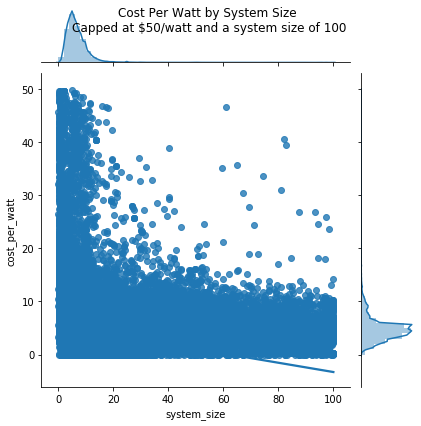

In [12]:
sns.jointplot(x='system_size' , y='cost_per_watt', kind='reg', 
              data=df.loc[(df['cost_per_watt'] < 50) & (df['system_size']<100)])
plt.suptitle('Cost Per Watt by System Size \nCapped at $50/watt and a system size of 100')
plt.show()

### The majority of system_size and cost_per_watt are both low. 

_____

## Median Cost Per Watt Per Year Given Size of System

In [159]:
pd.pivot_table(df, values='cost_per_watt',aggfunc='median', index='year', columns='sys_size_group', fill_value='-')

sys_size_group,"(0.0, 2.5]","(2.5, 5.0]","(5.0, 7.5]","(7.5, 10.0]","(10.0, 12.5]","(12.5, 17.5]","(17.5, 42.5]","(42.5, 18000.0]"
year,,,,,,,,
1998,20.755,6.700,5.110,-,-,20.71,-,0.250
1999,13.130,6.990,8.205,6.13,7.69,5.37,3.935,0.280
2000,14.580,9.795,9.630,7.01,10.765,-,-,3.840
2001,13.195,11.100,11.035,10.17,10.42,11.78,1.45,0.190
2002,13.490,11.340,10.810,9.345,10.69,9.08,9.94,0.260
2003,12.055,10.850,10.480,10.15,10.12,9.08,9.26,0.545
2004,11.800,10.140,9.840,9.65,9.33,9.175,9.4,9.140
2005,11.110,9.610,9.370,9.9,9.53,9.09,8.98,8.150
2006,11.000,9.840,9.530,9.615,9.08,9.05,8.84,8.505


### The larger the system size, the more volitility in the cost. Further, the larger systems seem to duplicate the distribution that the previous plot entitled "Installations above 10 dollars per watt by year" show

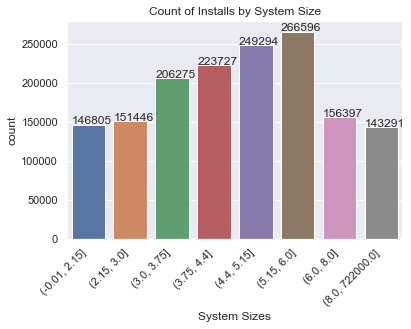

In [419]:
ax = sns.countplot(x='size_group', data=watt_groups)
plt.title('Count of Installs by System Size')
plt.xlabel('System Sizes')
plt.xticks( rotation=45, horizontalalignment='right',fontweight='light')
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x(), p.get_height()+200))
plt.show()

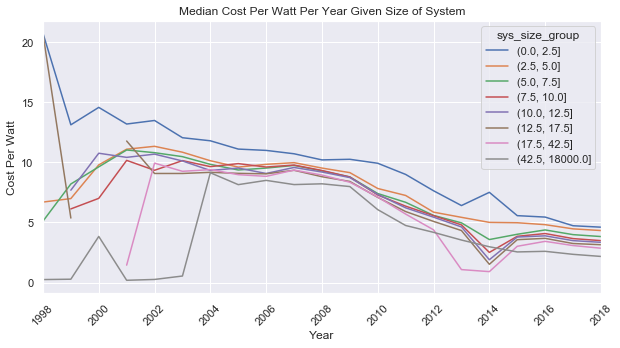

In [341]:
df.pivot_table(values='cost_per_watt',aggfunc='median', index='year', columns='sys_size_group').plot(figsize=(10,5))
plt.xticks(ticks= list(size_df.year.unique())[::2], rotation=45)
plt.title('Median Cost Per Watt Per Year Given Size of System')
plt.ylabel('Cost Per Watt')
plt.xlabel('Year')
plt.show()

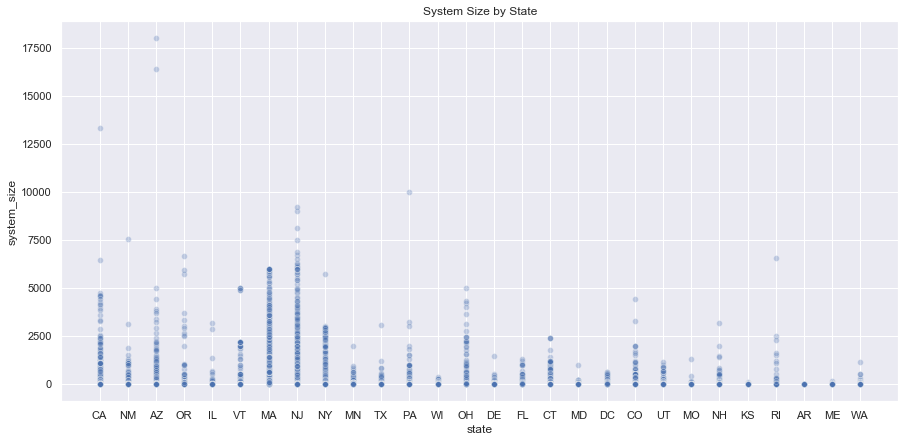

In [417]:
plt.figure(figsize=(15,7))
sns.scatterplot(x='state', y='system_size', data=df, alpha=0.3)
plt.title('System Size by State')
plt.show()

### It might help to understand if there is any one state which has larger systems than others. It looks as though New Jersey and Massachusetts have higher system sizes than other states. This could be something to take into consideration for doing feature importance in the future. 

----
#  STATE EDA

## Count of observations by State and Year

In [158]:
df.pivot_table(values='cost_per_watt', index='year', columns='state', aggfunc='count', fill_value='-')

state,AR,AZ,CA,CO,CT,DC,DE,FL,IL,KS,MA,MD,ME,MN,MO,NH,NJ,NM,NY,OH,OR,PA,RI,TX,UT,VT,WA,WI
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998,-,1.0,20.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,2.0,-,-,3.0,-,-,-,-,-,-,-
1999,-,66.0,117.0,-,-,-,-,-,14,-,-,-,-,-,-,-,-,3.0,-,-,18.0,-,-,-,-,1,-,-
2000,-,17.0,125.0,-,-,-,-,-,17,-,1,-,-,-,-,-,6,1.0,2,-,35.0,-,-,-,-,6,-,-
2001,-,4.0,1174.0,-,-,-,-,-,25,-,1,-,-,1,-,-,2,1.0,13,-,49.0,-,-,4,-,8,-,-
2002,-,9.0,2121.0,-,-,-,3,2,20,-,2,-,-,2,-,-,35,4.0,184,2,58.0,8,-,-,-,7,-,15
2003,-,31.0,2720.0,-,-,-,5,-,45,-,68,-,-,15,-,-,83,8.0,185,2,83.0,33,-,-,-,8,-,35
2004,-,49.0,4431.0,-,2,-,4,3,31,-,126,-,-,44,-,-,294,8.0,228,5,65.0,26,-,50,-,92,-,40
2005,-,104.0,4031.0,-,33,1,2,-,12,-,93,19,-,40,-,-,718,10.0,231,4,81.0,97,-,142,-,56,-,42
2006,-,326.0,6306.0,298,103,2,34,16,44,-,260,43,-,48,-,-,883,59.0,452,12,95.0,13,-,142,-,87,-,83


## Median Cost Per Watt Per Year Per State

In [160]:
pd.pivot_table(df, values='cost_per_watt',aggfunc='median', index='year', columns='state', fill_value='-')

state,AR,AZ,CA,CO,CT,DC,DE,FL,IL,KS,MA,MD,ME,MN,MO,NH,NJ,NM,NY,OH,OR,PA,RI,TX,UT,VT,WA,WI
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998,-,0.250,9.990,-,-,-,-,-,-,-,-,-,-,-,-,-,-,160.410,-,-,24.310,-,-,-,-,-,-,-
1999,-,6.470,12.030,-,-,-,-,-,24.155,-,-,-,-,-,-,-,-,10.020,-,-,23.355,-,-,-,-,11.79,-,-
2000,-,7.030,12.210,-,-,-,-,-,23.22,-,0,-,-,-,-,-,13.345,3.450,13.065,-,19.250,-,-,-,-,16.785,-,-
2001,-,0.405,11.560,-,-,-,-,-,16.51,-,7,-,-,2.85,-,-,11.79,4.060,13.21,-,16.570,-,-,10.44,-,15.44,-,-
2002,-,0.210,11.370,-,-,-,6.79,10.49,14.47,-,10.275,-,-,16.275,-,-,12.07,14.145,12.36,8.4,15.050,11.905,-,-,-,23.01,-,13.51
2003,-,5.830,10.655,-,-,-,12.62,-,14.61,-,12.235,-,-,12.94,-,-,11.15,12.470,10.52,7.47,10.080,11.82,-,-,-,17.845,-,13.02
2004,-,9.060,10.090,-,15.205,-,9.15,13.59,13.08,-,10.71,-,-,10.19,-,-,10.85,12.270,10.2,7.99,9.440,12.445,-,8.76,-,12.345,-,11.76
2005,-,8.705,9.500,-,10.53,2.33,12.63,-,13.665,-,10.73,13.99,-,11.76,-,-,10.385,10.400,9.82,6.835,9.520,11.02,-,8.425,-,13.5,-,11.26
2006,-,9.300,9.570,10.465,10.8,5.275,10.545,12.035,11.845,-,11.03,12.66,-,9.095,-,-,10.25,9.420,10.09,5.24,10.400,12.37,-,8.47,-,12.23,-,10.18


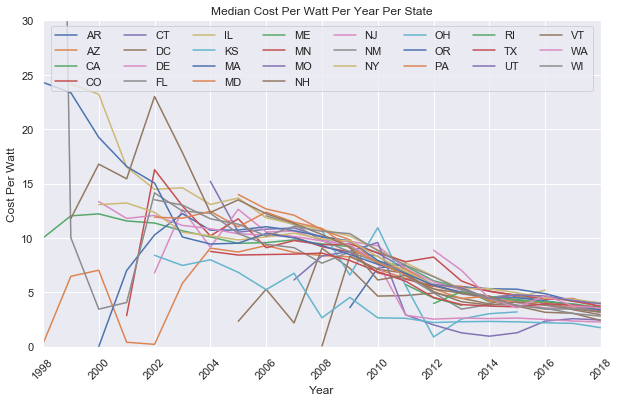

In [123]:
df.pivot_table(values='cost_per_watt',aggfunc='median', index='year', columns='state').plot(figsize=(10,6))
plt.xticks(ticks= list(size_df.year.unique())[::2], rotation=45)
plt.title('Median Cost Per Watt Per Year Per State')
plt.ylabel('Cost Per Watt')
plt.xlabel('Year')
plt.ylim(0,30)
plt.legend(loc='upper center', ncol=8)
plt.show()

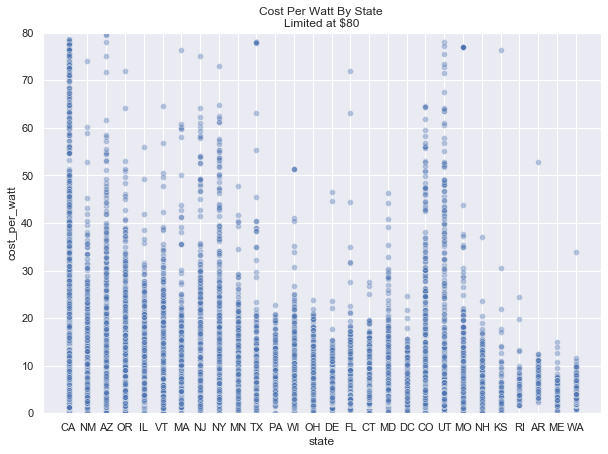

In [418]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='state', y='cost_per_watt', data=df, alpha=.4)
plt.title('Cost Per Watt By State \nLimited at $80')
plt.ylim(0,80)
plt.show()

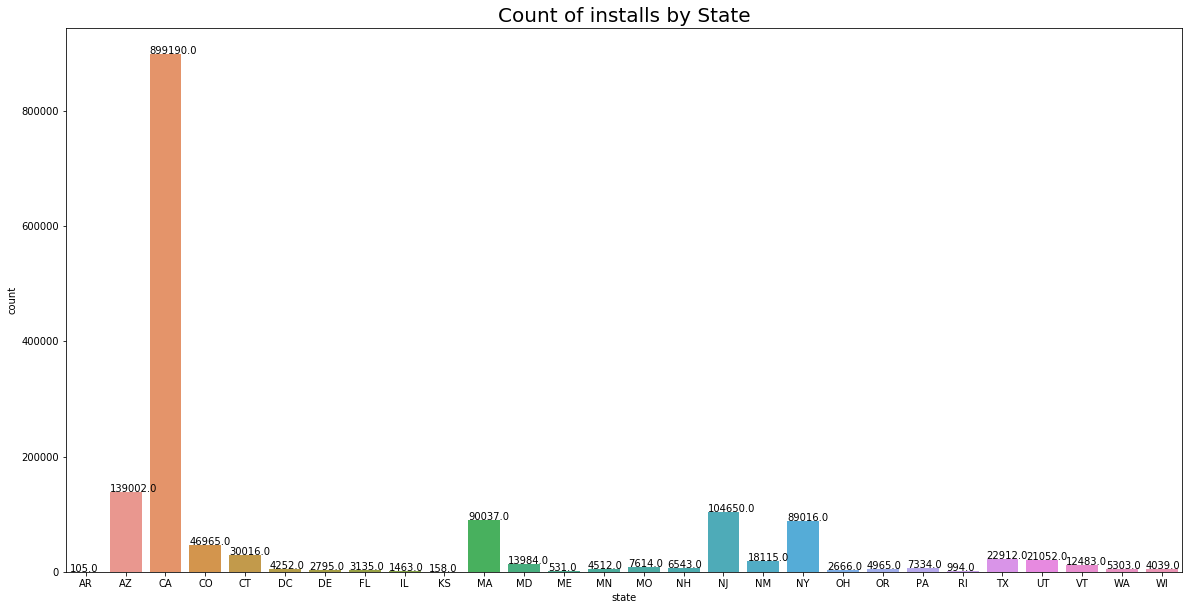

In [16]:
plt.figure(figsize=(20,10))
plt.tight_layout()
ax = sns.barplot(x='state', y='count', data=states)
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x(), (p.get_height())))
plt.title('Count of installs by State', fontsize=20)
plt.show()

### Of the 1543831 observations in the data, 899190 are from California which represents 58% of the data. While these do not necessarily represent all of the installations across the US(aka the population), it does represent a decent amount given the data was provided by governments and I assume many if not all customers of solar panels would want to partake in government incentive programs. As such, it seems well representative of the actual population rather than just the sample provided in the data set. 

----
# CUSTOMER SEGMENT EDA

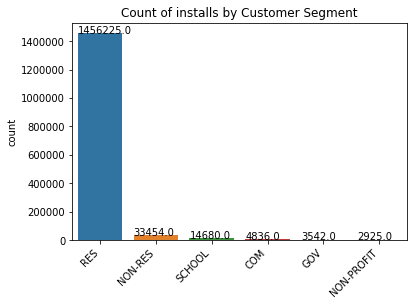

In [20]:
ax = sns.barplot(x=segs, y='count', data=df.groupby('customer_segment')['count', 'customer_segment'].count().sort_values('count', ascending=False))
for p in ax.patches:
        ax.annotate('{:}'.format(p.get_height()), (p.get_x(), (p.get_height())))
plt.xticks( rotation=45, horizontalalignment='right',fontweight='light')
plt.title('Count of installs by Customer Segment')
plt.show()

##### Amount of observations with an associated customer_segment
1515662  [~98%]
##### Amount of observations without an associated customer_segment
28169  [~2%]

## Count of Observations of Null Customer Segment Per Year Per State

In [162]:
df.loc[df.customer_segment.isna()==True].pivot_table(values='cost_per_watt', index='year', columns='state', aggfunc='count', fill_value='-')

state,AZ,CA,CO,CT,DC,DE,FL,IL,ME,MN,MO,NH,NJ,NM,OH,OR,RI,UT,WA
year,,,,,,,,,,,,,,,,,,,
1999,-,-,-,-,-,-,-,14,-,-,-,-,-,-,-,-,-,-,-
2000,-,-,-,-,-,-,-,17,-,-,-,-,-,-,-,-,-,-,-
2001,-,-,-,-,-,-,-,25,-,1,-,-,-,-,-,-,-,-,-
2002,-,-,-,-,-,-,-,20,-,1,-,-,-,-,2,-,-,-,-
2003,1,-,-,-,-,-,-,45,-,1,-,-,-,-,-,-,-,-,-
2004,1,-,-,-,-,-,-,31,-,9,-,-,-,-,1,-,-,-,-
2005,1,-,-,31,1,-,-,12,-,15,-,-,-,-,1,-,-,-,-
2006,4,-,1,93,-,-,-,44,-,14,-,-,2,-,5,-,-,-,-
2007,7,-,4,168,2,-,-,77,-,34,-,-,-,2,7,-,-,-,-
